# Tutorial: 3D molecular structure generation and optimization pipeline

This notebook presents a detailed walkthough for generation and optimization of 3D structures using open-source cheminformatics tools.
Modeling 3D molecular structures for studying their physicochemical properties and biological activity is crucial in modern chemistry.
By properly generating realistic (not always!) 3D structures we can develop statistical models to predict physical and biological properties of molecules.
Usual workflow consists of first generation of many conformers that are further subjected to geometry optimization routines or conformer sampling.
In this notebook we will use the GEOMOPT python package (LINK TO GITHUB REPO) to generate 25 conformers for a diverse set of 9 organic molecules. Then we will subject all molecules to geometry optimization.
Finally we will see how we can utilize 3D structure data to predict someting...

## Contents:
1. Reading molecules from their SMILES;
2. Conformer generation using RDKit;
3. Conformer preoptimization using semi-empirical tight-binding quantum mechanics (xTB);
4. Handling conformer ensembles;
5. Regression tasks.


## First lets import all the required packages

In [ ]:
import os
import shutil
import subprocess
import time

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
print(rdkit.__version__)
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from confworks.util import calc_rmsd_single_mol
from confworks.util import optimize_molecule

PATH = os.getcwd()

2024.03.3


## 1. Reading molecules from their SMILES

* First we will read molecules from a dataset that contains molecule SMILES and trivial names

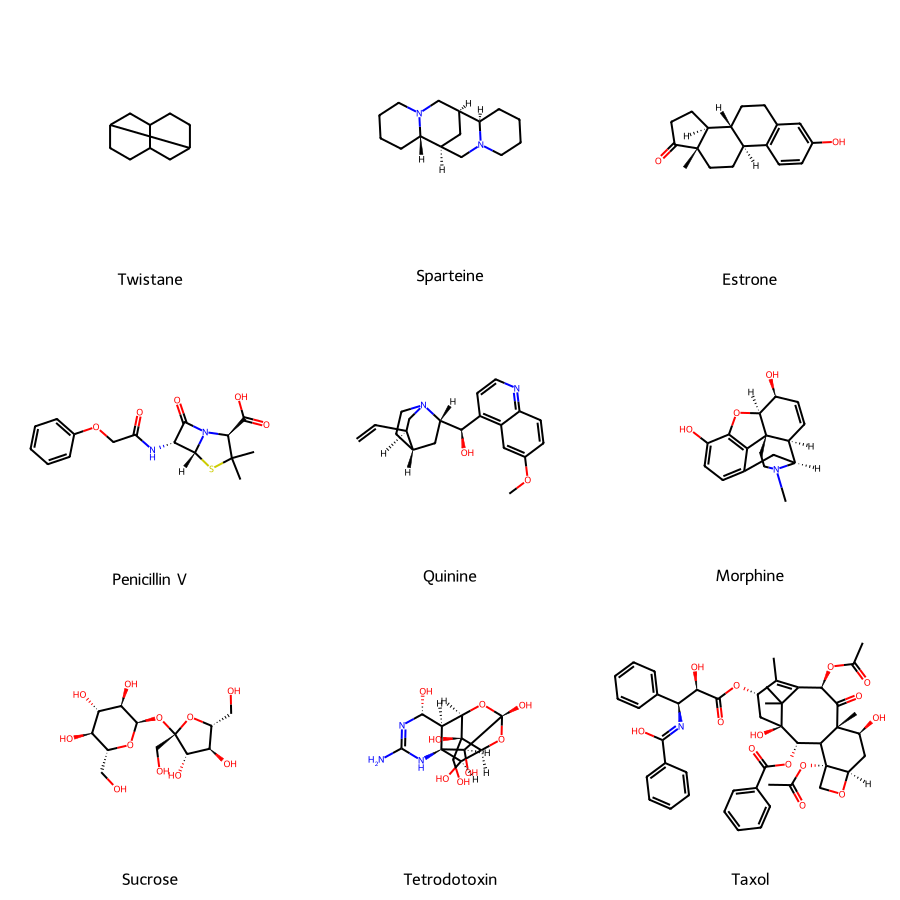

In [2]:
# Lets read our dataset of molecules as pandas dataframe
file_path = os.path.join(PATH, 'data', 'molecules.csv')
dataset = pd.read_csv(file_path)

mol_list = []

# Lets draw all molecules and their trivial names on a single image
for i, row in dataset.iterrows():
    smiles = row['smiles']
    name = row['name']
    mol = Chem.MolFromSmiles(smiles)
    mol.SetProp("_Name", name)
    mol_list.append(mol)

legends = [mol.GetProp('_Name') for mol in mol_list]
Draw.MolsToGridImage(mol_list, molsPerRow= 3, subImgSize=(300,300), legends=legends, returnPNG=False)

* We can already see 2D structures (graph representation) of our molecules;
* Next lets generate 25 conformers for each molecule using RDKit's ETKDG method;

In [ ]:
# Here we define conformer generation parameters
params = AllChem.EmbedParameters()
params.randomSeed = 42
params.numThreads = 4
params.timeout = 100
params.clearConfs = True
params.onlyHeavyAtomsForRMS = True
params.useRandomCoords = True
params.enforceChirality = True

NUM_CONFS = 25

mol_3D_list = []

statistics = {}

for mol in tqdm(mol_list[:]):
    mol_hs = Chem.AddHs(mol)
    time_1 = time.time()
    AllChem.EmbedMultipleConfs(mol_hs, NUM_CONFS, params)
    time_2 = time.time()

    # TODO how many conformers were generated for each molecule
    num_atoms = mol_hs.GetNumAtoms()
    statistics.setdefault('NumAtoms', []).append(num_atoms)
    
    num_heavy_atoms = mol_hs.GetNumHeavyAtoms()
    statistics.setdefault('NumHeavyAtoms', []).append(num_heavy_atoms)
    
    num_rot_bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol_hs)
    num_confs = mol_hs.GetNumConformers()
    statistics.setdefault('NumConfs', []).append(num_confs)
    
    # TODO lets plot how much time elapsed for generation per conformer
    delta_time = (time_2 - time_1) / num_confs
    statistics.setdefault('TimePerConf', []).append(delta_time)

    # TODO lets plot the average RMSD between conformers
    rmsd_list = calc_rmsd_single_mol(mol_hs)
    statistics.setdefault('MeanRMSD', []).append(np.mean(rmsd_list))
    
    # TODO torsion fingerprint -> how diverse the conformers are

    # TODO add a single function to util.py for plotting all of these above

    mol_3D_list.append(mol_hs)

100%|██████████| 9/9 [15:36<00:00, 104.02s/it]


In [ ]:
from confworks.util import save_multiconf_sdf

for i, mol_3D in enumerate(mol_3D_list):
    filepath = os.path.join(PATH, 'data', 'rdkit_mols', f'rdkit_mol_{i}.sdf')
    save_multiconf_sdf(mol_3D, filepath)

In [ ]:
from confworks.util import read_multiconf_sdf

mol_3D_list = []
for i in range(9):
    filepath = os.path.join(PATH, 'data', 'rdkit_mols', f'rdkit_mol_{i}.sdf')
    mol_3D = read_multiconf_sdf(filepath)
    mol_3D_list.append(mol_3D)
print(len(mol_3D_list))

9


Mean NumAtoms = 48.67
Mean NumHeavyAtoms = 24.78
Mean NumRotBonds = 6.33
Mean NumConfs = 25.0
Mean TimePerConf = 0.06
Mean MeanRMSD = 2.31



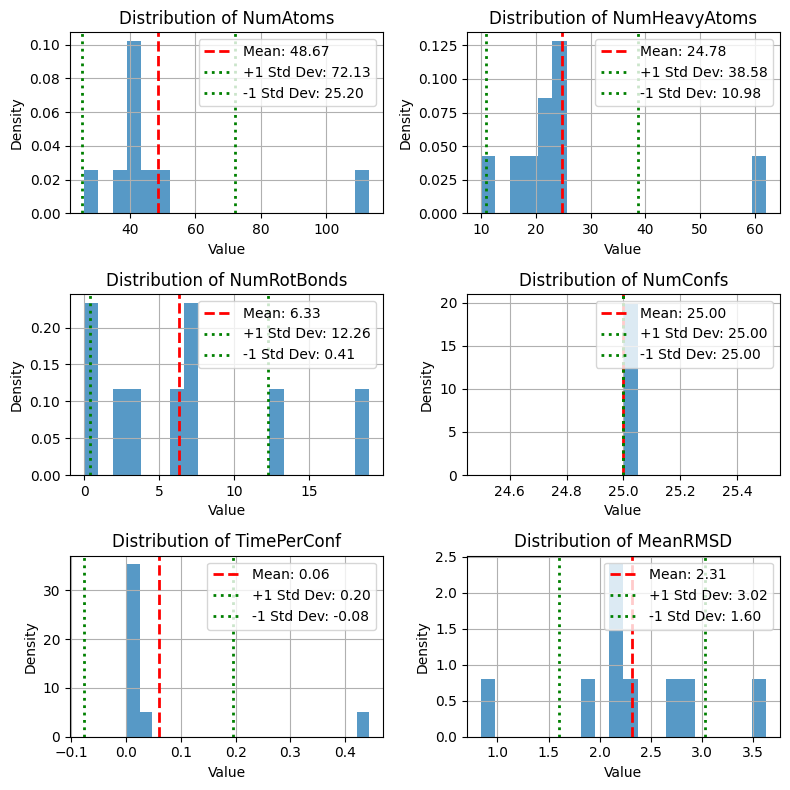

In [47]:
for key, val in statistics.items():
    avg_val = round(np.mean(val), 2)
    print(f'Mean {key} = {avg_val}')
print()

# --- Plotting ---
num_metrics = len(statistics)
# Adjust the number of rows and columns for your subplots
num_cols = 2
num_rows = (num_metrics + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (key, values) in enumerate(statistics.items()):
    ax = axes[i]
    # Plot histogram with density=True
    ax.hist(values, bins=20, alpha=0.75, density=True)
    # --- Calculate and plot statistics ---
    mean = np.mean(values)
    std = np.std(values)
    
    # Plot vertical line for the mean
    ax.axvline(mean, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
    
    # Plot vertical lines for +/- 1 standard deviation
    ax.axvline(mean + std, color='g', linestyle=':', linewidth=2, label=f'+1 Std Dev: {mean + std:.2f}')
    ax.axvline(mean - std, color='g', linestyle=':', linewidth=2, label=f'-1 Std Dev: {mean - std:.2f}')
    
    ax.set_title(f'Distribution of {key}')
    ax.set_xlabel('Value')
    # Update the y-axis label
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend() # Add a legend to show what the lines mean

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjusts subplot params so that subplots are nicely fit in the figure.
plt.show()

In [ ]:
mol_opt_list = []
statistics_xtb = {}
for mol_3d in tqdm(mol_3D_list):
    time_1 = time.time()
    mol_opt = optimize_molecule(mol_3d)
    time_2 = time.time()

    mol_opt_list.append(mol_opt)
    
    # TODO lets plot how much time elapsed for generation per conformer
    delta_time = (time_2 - time_1) / num_confs
    statistics_xtb.setdefault('TimePerConf', []).append(delta_time)

    # TODO lets plot the average RMSD between conformers
    rmsd_list = calc_rmsd_single_mol(mol_opt)
    statistics_xtb.setdefault('MeanRMSD', []).append(np.mean(rmsd_list))



## Saving molecules
* You may save your multiconformer molecules as separate SDF files using *save_multiconf_sdf* function from utils, which allows convenient storage of all conformers for a given molecule in a single sdf. Each conformer is assigned its conformer id and conformer energy (if present). For the below examples of xtb optimized geometries, respective xtb energies of conformers were recorded.

In [ ]:
# Lets save optimized 3D molecules
# Each SDF stores a separate molecule with all of its different conformers
# from confworks.util import save_multiconf_sdf
for i, mol_opt in enumerate(mol_opt_list):
    filepath = os.path.join(PATH, 'data', 'xtb_mols', f'xtb_mol_{i}.sdf')
    save_multiconf_sdf(mol_opt, filepath)

## Loading molecules
* In case you already have your dataset of 3D molecules (with multiple conformers) stored as SDFs, you may easily load them using *read_multiconf_sdf* function from utils.

In [7]:
mol_opt_list = []

for i in range(9):
    filepath = os.path.join(PATH, 'data', 'xtb_mols', f'xtb_mol_{i}.sdf')
    mol = read_multiconf_sdf(filepath)
    mol_opt_list.append(mol)

print(len(mol_opt_list))


9


Mean TimePerConf = 16.78
Mean MeanRMSD = 2.31



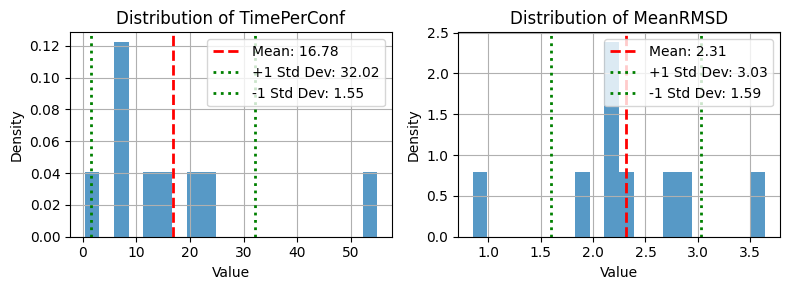

In [34]:
for key, val in statistics_xtb.items():
    avg_val = round(np.mean(val), 2)
    print(f'Mean {key} = {avg_val}')
print()

# --- Plotting ---
num_metrics = len(statistics_xtb)
# Adjust the number of rows and columns for your subplots
num_cols = 2
num_rows = (num_metrics + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (key, values) in enumerate(statistics_xtb.items()):
    ax = axes[i]
    # Plot histogram with density=True
    ax.hist(values, bins=20, alpha=0.75, density=True)
    # --- Calculate and plot statistics ---
    mean = np.mean(values)
    std = np.std(values)
    
    # Plot vertical line for the mean
    ax.axvline(mean, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
    
    # Plot vertical lines for +/- 1 standard deviation
    ax.axvline(mean + std, color='g', linestyle=':', linewidth=2, label=f'+1 Std Dev: {mean + std:.2f}')
    ax.axvline(mean - std, color='g', linestyle=':', linewidth=2, label=f'-1 Std Dev: {mean - std:.2f}')
    
    ax.set_title(f'Distribution of {key}')
    ax.set_xlabel('Value')
    # Update the y-axis label
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend() # Add a legend to show what the lines mean

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjusts subplot params so that subplots are nicely fit in the figure.
plt.show()

## Now lets make ensembles of conformers

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

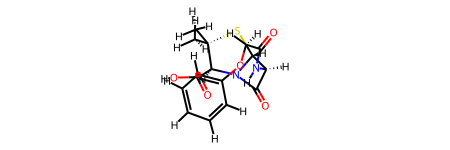

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

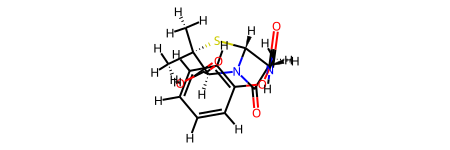

KeyError: 'conf_energy'

In [9]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol

i = 3
display(mol_3D_list[i])
display(mol_opt_list[i])

print(mol_opt_list[i].GetConformer(0).GetDoubleProp('conf_energy'))

In [3]:
path_to_xyz = base_path + f'/xyz'
path_to_xtbopt = base_path + f'/xtb'

def clean_directory(directory):
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist. Creating...")
        try:
            os.makedirs(directory)  # Create the directory and any missing parent directories
            print(f"Directory '{directory}' created successfully.")
        except Exception as e:
            print(f"Error creating directory '{directory}': {e}")
        return

    # Check if it's a directory
    if not os.path.isdir(directory):
        print(f"'{directory}' is not a directory.")
        return

    # Get list of files and subdirectories in the directory
    files_and_subdirectories = os.listdir(directory)

    # If the directory is empty, do nothing
    if not files_and_subdirectories:
        print(f"Directory '{directory}' is empty. Nothing to delete.")
        return

    # If the directory is not empty, delete files and subdirectories recursively
    for item in files_and_subdirectories:
        item_path = os.path.join(directory, item)
        try:
            if os.path.isfile(item_path):
                os.remove(item_path)
                print(f"Deleted file: {item}")
            elif os.path.isdir(item_path):
                clean_directory(item_path)  # Recursively delete subdirectories
                os.rmdir(item_path)  # Remove the empty subdirectory
                print(f"Deleted directory: {item_path}")
        except Exception as e:
            print(f"Error deleting {item_path}: {e}")

In [4]:
clean_directory(path_to_xyz)

for i, mol in tqdm(enumerate(mol_list)):
    if mol is None:
        continue
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)
    time.sleep(0.05)
    try:
        xyz_content = f"{mol.GetNumAtoms()}\n"

        if mol_list[0].HasProp("_Name"):
            xyz_content += f'{mol.GetProp("_Name")}\n'
        else:
            xyz_content += "\n"
        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            xyz_content += f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}\n"


        for atom in mol.GetAtoms():
            pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
            xyz_content += f"{atom.GetSymbol()} {pos.x} {pos.y} {pos.z}\n"
    except:
        continue

    with open(path_to_xyz + f"/xtb_input_{i}.xyz", "w") as xyz_file:
        xyz_file.write(xyz_content)


Deleted file: xtb_input_1.xyz
Deleted file: xtb_input_0.xyz
Deleted file: xtb_input_3.xyz
Deleted file: xtb_input_2.xyz


4it [00:02,  1.56it/s]


## Geometry optimization using xTB-python